# 2021-11-05 Galerkin methods

## Last time

* Project discussion
* Weak forms

## Today

* Variational forms
* Finite element definition
* From prime to nodal bases
* Galerkin method
* Finite element assembly

In [1]:
using Plots
using LinearAlgebra

# Integration by parts

## One dimension

> it's the product rule backwards

\begin{align} \int_a^b d(uv) &= \int_a^b u dv + \int_a^b v du \\
(uv)_a^b &= \int_a^b u dv + \int_a^b v du \\
\int_a^b u dv &= (uv)_a^b - \int_a^b v du
\end{align}

> you can move the derivative to the other term; it'll cost you a minus sign and a boundary term

## Multiple dimensions

\begin{align}
\int_\Omega v \nabla\cdot \mathbf f = -\int_\Omega \nabla v \cdot \mathbf f + \int_{\partial \Omega} v \mathbf f \cdot \mathbf n
\end{align}

## Strong form

$$ -\nabla\cdot(\kappa \nabla u) = 0 $$

## Weak form
* multiply by a test function and integrate by parts

\begin{align} -\int_\Omega v \nabla\cdot(\kappa \nabla u) = 0, \forall v \\
\int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0
\end{align}

# Variational: from minimization to weak forms

## Minimization

Find $u\in \mathcal V$ such that

\begin{align}
u &= \arg\min \int_\Omega \frac 1 p \lVert \nabla u \rVert^p \\
&= \arg\min \int_\Omega \frac 1 p (\nabla u \cdot \nabla u)^{p/2}
\end{align}

## Variations

> If $f(x)$ is a minimum, then $df = f'(x) dx = 0$ for all $dx$.

So if $u \in \mathcal V$ is a minimizer, then 
\begin{align}
\int_\Omega \underbrace{\lVert \nabla u \rVert^{p-2}}_{\kappa(u)} \nabla u \cdot \nabla du = 0
\end{align}
for all $du \in \mathcal V$.

* It's common to use $v$ in place of $du$.
* Our discretization will reflect this structure

$$ v_h^T F(u_h) \sim \int_\Omega \nabla v \cdot \kappa(u) \cdot \nabla u $$

# Finite elements

## Problem statement

Find $u \in \mathcal V$ such that
\begin{align} \int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0, \forall v \in \mathcal V
\end{align}

### What do we need?
* A way to integrate
* A space $\mathcal V$
* Boundary conditions

## Ciarlet (1978) definition

A **finite element** is a triple $(K, P, N)$ where
* $K$ is a bounded domain with piecewise smooth boundary
* $P = \{p_j\}_1^k$ is a finite-dimensional function space over $K$ ("prime basis")
* $N = \{n_i\}_1^k$ is a basis for the dual space ("nodes")

It is common for nodes to be pointwise evaluation
$$ \langle n_i, p_j \rangle = p_j(x_i) $$

### First: choose a single element $K = \Omega$

# Quadrature

Our elements will be a line segment and we'll define quadrature on the standard line segment, $\hat K = (-1, 1)$. A quadrature is a set of points $q_i$ and weights $w_i$ such that
$$ \int_{-1}^1 f(x) \approx \sum_{i=1}^n w_i f(q_i) $$

In [44]:
default(linewidth=4)
function quad_trapezoid(n)
    q = LinRange(-1, 1, n)
    w = 2 * ones(n) / (n - 1)
    w[[1,end]] ./= 2
    q, w
end

function plot_quad_accuracy(f, F, quad)
    ns = 2 .^ (2:7)
    exact = F(1) - F(-1)
    function err(n)
        q, w = quad(n)
        w' * f.(q) - exact
    end
    errors = [abs.(err(n)) for n in ns]
    plot(ns, errors, marker=:auto, label=quad)
    plot!(ns, ns.^(-2), xscale=:log10, yscale=:log10)    
end

plot_quad_accuracy (generic function with 1 method)

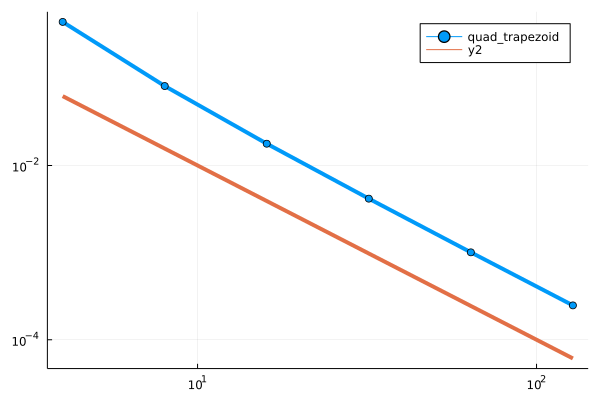

In [51]:
plot_quad_accuracy(exp, exp, quad_trapezoid)
plot_quad_accuracy(x -> 3*x^2, x -> x^3, quad_trapezoid)

# Integration via polynomial interpolation

* Pick some points $x_i$
* Evaluate the function there $f_i = f(x_i)$
* Find the polynomial that interpolates the data
* Integrate the polynomial

## What order of accuracy can we expect?
* What degree polynomials can be integrate exactly?

# Doing better: Gauss quadrature

Suppose a polynomial on the interval $[-1,1]$ can be written as

$$ P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Why is $\int_{-1}^1 P_n(x) q(x) = 0$?
* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

# Gauss-Legendre in code

1. Solve for the points, compute the weights
  * Use a Newton solver to find the roots. You can use the recurrence to write a recurrence for the derivatives.
  * Create a Vandermonde matrix and extract the first row of the inverse or (using more structure) the derivatives at the quadrature points.
2. Use duality of polynomial roots and matrix eigenvalues.
  * A fascinating mathematical voyage (topic of graduate linear algebra class).

In [52]:
function gauss_legendre(n)
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = @. .5 / sqrt(1 - (2 * (1:n-1))^(-2))
    T = diagm(-1 => beta, 1 => beta)
    D, V = eigen(T)
    w = V[1,:].^2 * 2
    q = D
    q, w
end

gauss_legendre (generic function with 1 method)

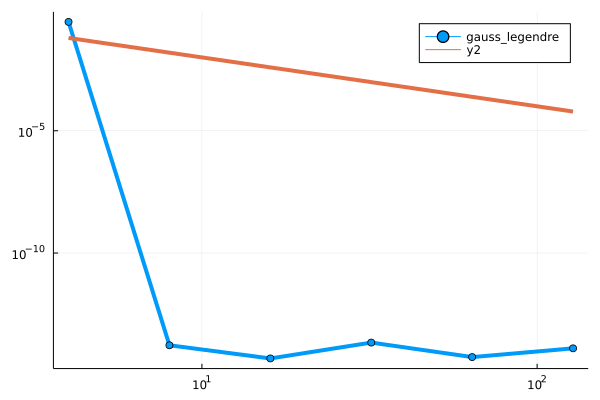

In [54]:
plot_quad_accuracy(exp, exp, gauss_legendre)
plot_quad_accuracy(x -> 11*x^10, x -> x^11, gauss_legendre)

# Legendre polynomials

In [55]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

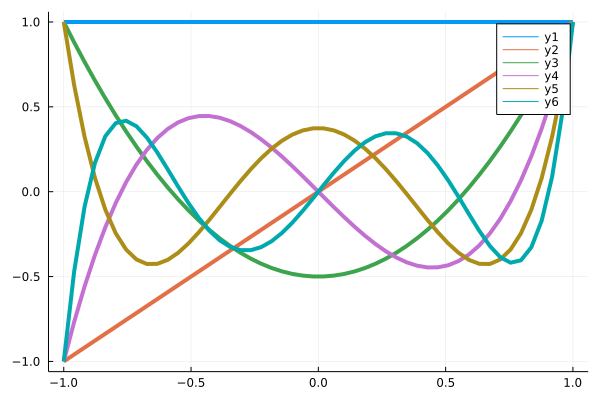

In [56]:
x = LinRange(-1, 1, 50)
P = vander_legendre(x, 6)
plot(x, P)

# Prime to nodal basis

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = \langle n_i, p_j \rangle$,
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

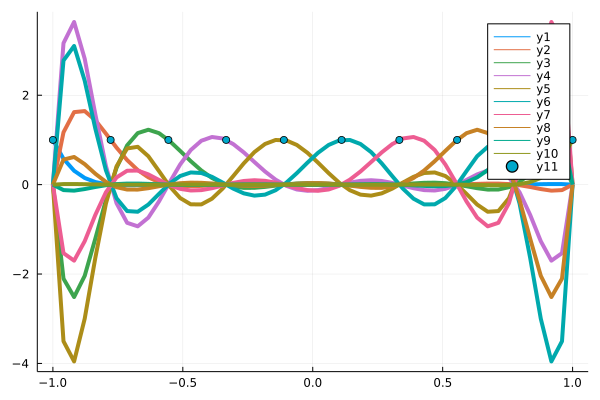

In [58]:
k = 10
xn = LinRange(-1, 1, k)
V = vander_legendre(xn)
xx = LinRange(-1, 1, 50)
Pxx = vander_legendre(xx, k)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

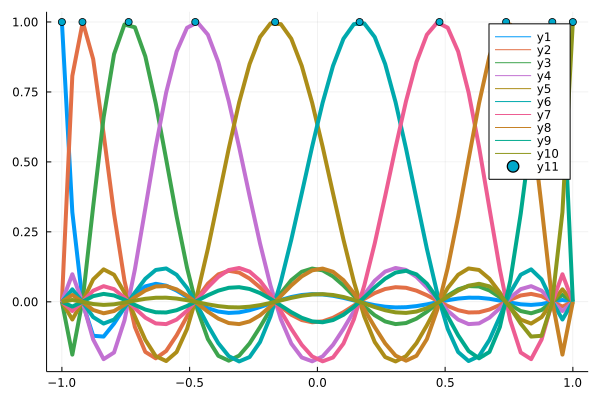

In [59]:
using FastGaussQuadrature
xn, _ = gausslobatto(k)
V = vander_legendre(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

# Galerkin method: $L^2$ projection

A nice test problem that doesn't require derivatives or boundary conditions:
Find $u \in \mathcal V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

In [60]:
function febasis(P, Q)
    x, _ = gausslobatto(P)
    q, w = gausslegendre(Q)
    Pk = vander_legendre(x)
    Pq = vander_legendre(q, P)
    B = Pq / Pk
    x, q, w, B
end

function L2_galerkin(P, Q, f)
    x, q, w, B = febasis(P, Q)
    A = B' * diagm(w) * B
    rhs = B' * diagm(w) * f.(q)
    u = A \ rhs
    x, u
end

L2_galerkin (generic function with 1 method)

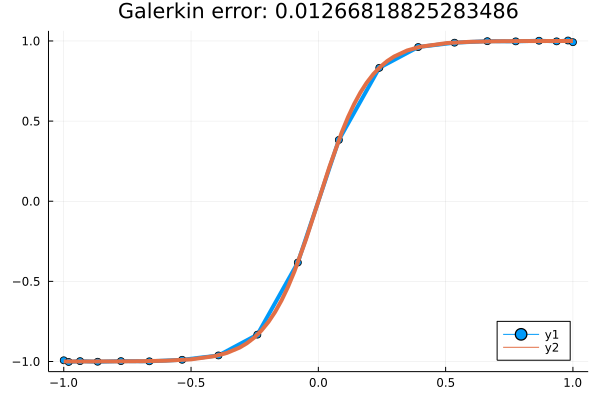

In [64]:
f(x) = tanh(5*x)
x, u = L2_galerkin(20, 20, f)
error = u - f.(x)
plot(x, u, marker=:auto, legend=:bottomright)
plot!(f, title="Galerkin error: $(norm(error))")

# Convergence of the Galerkin method

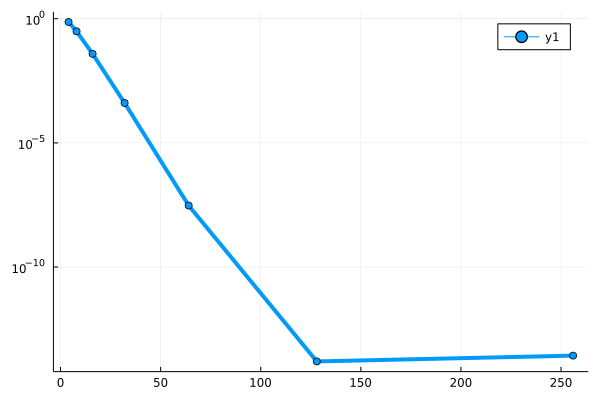

In [67]:
ns = 2 .^ (2:8)
function L2_error(n)
    x, u = L2_galerkin(n, n, f)
    norm(u - f.(x))
end
plot(ns, L2_error.(ns), marker=:auto, yscale=:log10)

# Galerkin error estimates

We introduce the notation
$$ a(v, u) = \int_\Omega \nabla v(x) \cdot \nabla u(x) $$
and note that $a$ is
* bilinear (linear in each of its arguments)
* symmetric: $a(u, v) = a(v,u)$
* positive definite: $a(u, u) > 0$ when $u \ne 0$
thus defines an inner product on the function space $V$.

We also introduce the $L^2$ inner product
$$ \langle u, v \rangle = \int_\Omega u(x) v(x) $$
so that our continuous weak form is to find $u \in V$ such that
$$ a(v, u) = \langle v, f \rangle, \quad \forall v\in V. $$
Our Galerkin discretization is to find $u_h \in V_h \subset V$ such that
$$ a(v_h, u_h) = \langle v_h, f \rangle, \quad \forall v_h \in V_h . $$
Since $V_h \subset V$, we can subtract these two, yielding
$$ a(v_h, u_h - u) = 0, \quad \forall v_h \in V_h .$$
This says that the error in the discrete solution $u_h - u$ is $a$-orthogonal to all test functions $v_h$.

# Galerkin optimality via energy norms

We can also define the "energy norm" or $a$-norm,
$$ \lVert u \rVert_a = \sqrt{a(u,u)} . $$
This norm satisfies the Cauchy-Schwarz inequality,
$$ \lvert a(u,v) \rvert \le \lVert u \rVert_a \lVert v \rVert_a . $$
Now,
\begin{align}
\lVert u_h - u \rVert_a^2 &= a(u_h - u, u_h - u) \\
&= a(u_h - v_h, u_h - u) + a(v_h - u, u_h - u) \\
&= a(v_h - u, u_h - u) \\
&\le \lVert v_h - u \rVert_a \lVert u_h - u \rVert_a .
\end{align}
In other words,
$$\lVert u_h - u \rVert_a \le \lVert v_h - u \rVert_a, \quad \forall v_h \in V_h .$$
So the solution $u_h$ computed by the Galerkin discretization is optimal over the subspace $V_h$ as measured in the $a$-norm.

## Observations
* The Galerkin method computes the exact solution any time it resides in the subspace $V_h$.
* The Galerkin method is automatically symmetric any time the weak form is symmetric.
* The Galerkin method can be spectrally accurate, similar to the Chebyshev finite difference methods.
* For a nonlinear problem, discretization and differentiation will commute.

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |